In [32]:
import torch
import torch.onnx as onnx
import torchvision.models as models
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import numpy as np
import matplotlib.pyplot as plt
import torchvision

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [34]:
training_data = torchvision.datasets.MNIST(
    '/files/',
    train=True,
    download=True,
    transform=torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
                                              torchvision.transforms.Normalize((0.1307,), (0.3081,))]
                                             )
)

test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, download=True, transform=transforms.Compose([
            transforms.ToTensor(),
            ])),
        batch_size=1, shuffle=True)

In [35]:
train_dataloader = DataLoader(training_data, 64, shuffle=True)
epochs = 3
learning_rate = 0.01
momentum = 0.5
log_interval = 10
batch_size = 64

random_seed = 1
torch.backends.cudnn.enabled = False
torch.manual_seed(random_seed)

In [36]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
use_cuda=True

In [37]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if (use_cuda and torch.cuda.is_available()) else "cpu")
# Initialize the network
model = Net().to(device)

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

CUDA Available:  False


In [38]:
def train_loop(dataloader, model, loss_fn, optimizer, epsilon):
    size = len(dataloader.dataset)
    for batch, (data, target) in enumerate(train_dataloader):
        # Compute prediction and loss
        data.requires_grad = True
        pred = model(data)
        loss = loss_fn(pred, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        optimizer.step()

        # Adversarial Training portion
        
        # Compute prediction and loss
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        pred2 = model(perturbed_data)
        loss = loss_fn(pred2, target)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(data)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [39]:

epochs = 3
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loop(train_dataloader, model, loss_fn, optimizer, epsilon = 0.3)
print("Done!")

Epoch 1
-------------------------------
loss: 2.326904  [    0/60000]
loss: 2.264989  [ 6400/60000]
loss: 1.879373  [12800/60000]
loss: 1.383790  [19200/60000]
loss: 1.040724  [25600/60000]
loss: 1.134262  [32000/60000]
loss: 0.986145  [38400/60000]
loss: 0.808828  [44800/60000]
loss: 0.705778  [51200/60000]
loss: 0.778318  [57600/60000]
Epoch 2
-------------------------------
loss: 0.855881  [    0/60000]
loss: 0.583941  [ 6400/60000]
loss: 0.794840  [12800/60000]
loss: 0.598454  [19200/60000]
loss: 0.565409  [25600/60000]
loss: 0.575952  [32000/60000]
loss: 0.612038  [38400/60000]
loss: 0.615355  [44800/60000]
loss: 0.580869  [51200/60000]
loss: 0.441237  [57600/60000]
Epoch 3
-------------------------------
loss: 0.470725  [    0/60000]
loss: 0.519925  [ 6400/60000]
loss: 0.501613  [12800/60000]
loss: 0.394374  [19200/60000]
loss: 0.629018  [25600/60000]
loss: 0.576622  [32000/60000]
loss: 0.434149  [38400/60000]
loss: 0.423434  [44800/60000]
loss: 0.564568  [51200/60000]
loss: 0.25

In [40]:
model.eval()

Net(
  (conv1): Conv2d(1, 10, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv2_drop): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=320, out_features=50, bias=True)
  (fc2): Linear(in_features=50, out_features=10, bias=True)
)

In [41]:
def fgsm_attack(image, epsilon, data_grad):
    sign_data_grad = data_grad.sign()
    perturbed_image = image + epsilon*sign_data_grad
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image

In [42]:
def test( model, device, test_loader, epsilon, realValue):

    # Accuracy counter
    correct = 0
    adv_examples = []

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)

        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        # if init_pred.item() != target.item():
        #     continue

        # Calculate the loss
        loss = F.nll_loss(output, target)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)

        # Re-classify the perturbed image
        output = model(perturbed_data)

        # Check for success
        final_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
        if realValue == 1:
            if final_pred.item() == target.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 50):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
        else:
            if final_pred.item() == init_pred.item():
                correct += 1
                # Special case for saving 0 epsilon examples
                if (epsilon == 0) and (len(adv_examples) < 50):
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )
            else:
                # Save some adv examples for visualization later
                if len(adv_examples) < 5:
                    adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                    adv_examples.append( (init_pred.item(), final_pred.item(), adv_ex) )

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_loader))
    print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_loader), final_acc))

    # Return the accuracy and an adversarial example
    return final_acc, adv_examples

In [43]:
accuracies = []
examples = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, realValue = 1)
    accuracies.append(acc)
    examples.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 9624 / 10000 = 0.9624
Epsilon: 0.05	Test Accuracy = 9148 / 10000 = 0.9148
Epsilon: 0.1	Test Accuracy = 8263 / 10000 = 0.8263
Epsilon: 0.15	Test Accuracy = 6875 / 10000 = 0.6875
Epsilon: 0.2	Test Accuracy = 4906 / 10000 = 0.4906
Epsilon: 0.25	Test Accuracy = 2826 / 10000 = 0.2826
Epsilon: 0.3	Test Accuracy = 1131 / 10000 = 0.1131


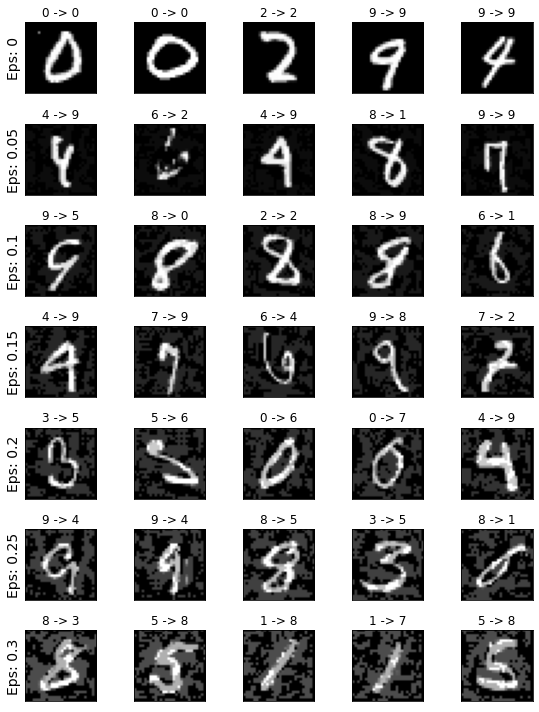

In [44]:
cnt = 0
plt.figure(figsize=(8,10))
for i in range(len(epsilons)):
    for j in range(5):
        cnt += 1
        plt.subplot(len(epsilons),5,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        currArr = examples[i]
        orig,adv,ex = currArr[j]
        plt.title("{} -> {}".format(orig, adv))
        plt.imshow(ex, cmap="gray")
plt.tight_layout()
plt.show()

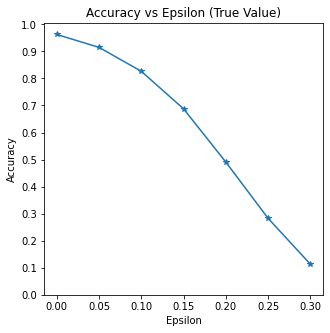

In [45]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (True Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [46]:
accuracies2 = []
examples2 = []

 #Run test for each epsilon
for eps in epsilons:
    acc, ex = test(model, device, test_loader, eps, realValue = 0)
    accuracies2.append(acc)
    examples2.append(ex)

# epsilon = 0.3
# acc, ex = test(model, device, test_loader, eps)
# accuracies.append(acc)

a, b, c, d, e, f, g = examples;

Epsilon: 0	Test Accuracy = 10000 / 10000 = 1.0
Epsilon: 0.05	Test Accuracy = 9498 / 10000 = 0.9498
Epsilon: 0.1	Test Accuracy = 8594 / 10000 = 0.8594
Epsilon: 0.15	Test Accuracy = 7191 / 10000 = 0.7191
Epsilon: 0.2	Test Accuracy = 5206 / 10000 = 0.5206
Epsilon: 0.25	Test Accuracy = 3113 / 10000 = 0.3113
Epsilon: 0.3	Test Accuracy = 1408 / 10000 = 0.1408


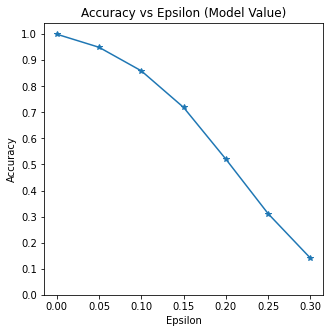

In [53]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies2, "*-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (Model Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [48]:
writtenAccuracies = [1, 0.9473, 0.8425, 0.6539, 0.3932, 0.1898, 0.0818]

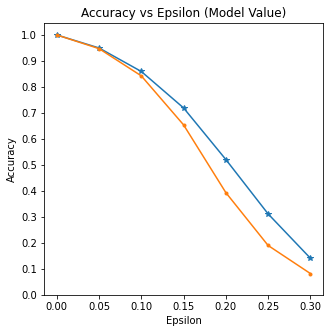

In [50]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies2, "*-")
plt.plot(epsilons, writtenAccuracies, ".-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (Model Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()

In [51]:
writtenAccuracies2 = [0.9657, 0.9154, 0.8135, 0.6271, 0.3682, 0.1672, 0.0615]

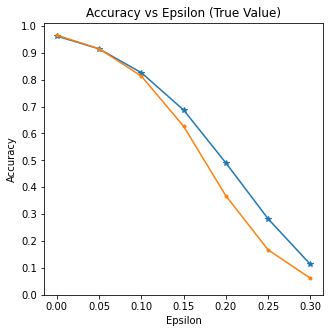

In [52]:
plt.figure(figsize=(5,5))
plt.plot(epsilons, accuracies, "*-")
plt.plot(epsilons, writtenAccuracies2, ".-")
plt.yticks(np.arange(0, 1.1, step=0.1))
plt.xticks(np.arange(0, .35, step=0.05))
plt.title("Accuracy vs Epsilon (True Value)")
plt.xlabel("Epsilon")
plt.ylabel("Accuracy")
plt.show()